In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files


def softmax(X):                                                                 ###converts log probabilities to probabilities
  norm = np.sum(np.exp(X)+10**-5)
  Y = (np.exp(X)+10**-5)/norm
  return Y

def softmax_dim2(X):                                                            ###converts matrix of log probabilities to matrix of probabilities
  norm = np.sum(np.exp(X)+10**-5,axis=0)
  Y = (np.exp(X)+10**-5)/norm
  return Y

def normalise(X):                                                               ###normalises a matrix of probabilities
  X= X/np.sum(X,0)
  return X

def normalise(X):                                                               ###normalises a matrix of probabilities
  X= X/np.sum(X,0)
  return X

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

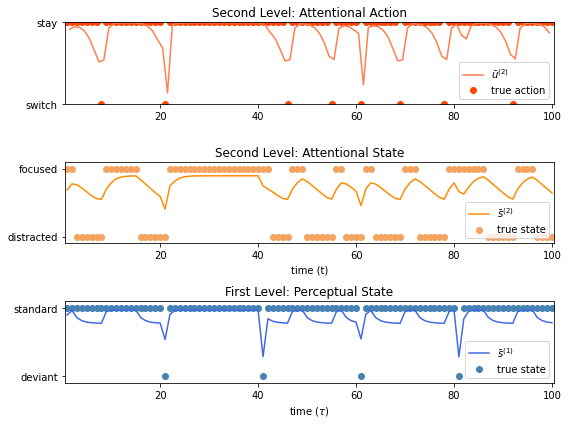

In [ ]:
####### Mind-wandering during an odd-ball perceptual task
####### Two-level model with single factor at each level

################################################################################
### Defining parameters
################################################################################

fig7=0                      ### Setting parameters for each figure
fig10=1


T = 100                     ### Number of time-steps
Pi2 = np.zeros((2,T))       ### prior attentional actions (stay, switch)
Pi2bar = np.zeros((2,T))    ### posterior attentional actions (stay, switch)

E2 = np.array([0.99,0.99])    ### prior over attentional policies
gammaG2 = 4.0
C2 = np.array([2,-2])       ### preference over attentional outcomes (agent is trying to perform the task - ie. maintain attention on the stimulous)

X3 = np.zeros((2,T))        ### meta-awareness states prior (high vs low precision)
X3bar = np.zeros((2,T))     ### meta-awareness states posterior (high vs low precision)


X2 = np.zeros((2,T))        ### attentional states prior (high vs low precision)
X2bar = np.zeros((2,T))     ### attentional states posterior (high vs low precision)

x2 = np.zeros(T)            ### discrete generative process states --> x2 sets gammaA1
x2[0] = 0                   ### start in a focused state
u2 = np.zeros(T)            ### discrete generative process active states --> u2 sets transition probabilities for x2


X1 = np.zeros((2,T))        ### perception prior (standard vs oddball)
X1bar = np.zeros((2,T))     ### perception posterior (standard vs oddball)

O = np.zeros(T)             ### observations (standard vs oddball)

O[int(T/5)]=1;              ### generative process determined by experimenter
O[int(2*T/5)]=1;              ### generative process determined by experimenter
O[int(3*T/5)]=1;              ### generative process determined by experimenter
O[int(4*T/5)]=1;              ### generative process determined by experimenter


O1 = np.zeros((2,T))        ### observation prior (standard vs oddball)
O1bar = np.zeros((2,T))     ### observation posterior (standard vs oddball)
for t in range(T):
  O1bar[int(O[t]),t]=1

X3[:,0] = [1.0,0]           ### meta-awareness state prior D3
X2[:,0] = [0.5,0.5]         ### attentional state prior D2
X1[:,0] = [0.5,0.5]         ### perceptual state prior D1

######## Defining transition matrices  ##########

B3 = np.zeros((2,2))
B3[:,0]=[.9,0.1]           ###probability of high/low meta-awareness, given high meta-awareness
B3[:,1]=[0.1,.9]          ###probability of high/low meta-awareness, given low meta-awareness


B2a = np.zeros((2,2))       ### maintain attentional state - "stay"
B2b = np.zeros((2,2))       ### switch atttentional state - "switch"

B2a[:,0]=[.8,0.2]           ###probability of focus/distracted, given focus+stay
B2a[:,1]=[0.0,1.0]          ###probability of focus/distracted, given distracted+stay

B2b[:,0]=[0.0,1.0]          ###probability of focus/distracted, given focus+switch
B2b[:,1]=[1.0,0.0]          ###probability of focus/distracted, given distracted+switch

B2t = np.zeros((2,2,2))
B2t[:,:,0]=B2a
B2t[:,:,1]=B2b

B1 = np.zeros((2,2))
B1[:,0]=[0.8,0.2]
B1[:,1]=[0.2,0.8]

######## Defining likelihood matrices  ##########

A1 = np.zeros((2,2))
A1[:,0] = [0.75,0.25]
A1[:,1] = [0.25,0.75]
gammaA1 = np.zeros(T)

betaA1m = np.zeros(2)
betaA1m[:] = [0.5,2.0]

A2 = np.zeros((2,2))
A2[:,0] = [0.75,0.25]
A2[:,1] = [0.25,0.75]
gammaA2 = 1.0
A2 = softmax_dim2(np.log(A2)*gammaA2)

######## Setting up F & G calculations #######

H2 = np.zeros(2)
H2[0] = np.inner(A2,np.log(A2))[0,0]
H2[1] = np.inner(A2,np.log(A2))[1,1]

G2 = np.zeros((2,T))
F2 = np.zeros((2,T))

################################################################################
### Running the simulation
################################################################################


### State belief updating
for t in range(T):

  betaA1 = np.sum(betaA1m*np.inner(A2,X2[:,t])) ### Bayesian model average (prior precision beliefs)
  gammaA1[t] = betaA1m[int(x2[t])]**-1          ### actual precision is based on generative process (earlier it was betaA1**-1)

  A1bar = softmax_dim2(A1**gammaA1[t])          ### Precision weighted likelihood mapping
  O1[:,t] = np.inner(A1bar,X1[:,t])             ### Observation priors

  X1bar[:,t] = softmax(np.log(X1[:,t])+gammaA1[t]*np.log(A1[int(O[t]),:])) ## calculate perceptual state posterior

  AtC = 0                                       ### "attentional charge" - inverse precision updating term

  for i in range(2):                            ##loop over outcomes
    for j in range(2):                          ##loop over states
      AtC += (O1bar[i,t]-A1bar[i,j])*X1bar[j,t]*np.log(A1[i,j])   ### See "Uncertainty, epistemics and active inference" Parr, Friston.
  if AtC > betaA1m[0]:
    AtC = betaA1m[0]-10**-5

  betaA1bar = betaA1 - AtC                      ## inverse precision posterior

  X2bar[:,t] = softmax(np.log(X2[:,t])-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))  ## calculate attentional state posterior given precision beliefs


### Policy selection

  if t<(T-1):
    X2a = np.inner(B2a,X2bar[:,t])
    O2a = np.inner(A2,X2a)

    X2b = np.inner(B2b,X2bar[:,t])
    O2b = np.inner(A2,X2b)

    #print("t:",t, "X2a:",X2a, "X2b:", X2b, "X2bar:",X2bar[:,t])

    G2[0,t] = np.sum(O2a*(np.log(O2a)-C2)-X2a*H2)
    G2[1,t] = np.sum(O2b*(np.log(O2b)-C2)-X2b*H2)
    #print("O2a:",O2a,"O2b:",O2b)
    Pi2[:,t] = softmax(np.log(E2)-gammaG2*G2[:,t])
    #print("Pi2:",Pi2[:,t],"G2:",G2[:,t])


    B2 = B2a*Pi2[0,t]+B2b*Pi2[1,t]
    X2[:,t+1] = np.inner(B2,X2bar[:,t]) ###evolve expected state
    X1[:,t+1] = np.inner(B1,X1bar[:,t])

    u2[t] = np.arange(2)[Pi2[:,t]==np.amax(Pi2[:,t])] ###generative process is discrete

     ### generative process driving attentional states
    if fig7:
      if t<T/2:
        x2[t+1] = 0 ##set to focused
      else:
        x2[t+1] = 1 ##set to distracted
    else:
      if u2[t]==0:
        x2[t+1] = np.random.choice([0,1],p=B2a[:,int(x2[t])]) ###generate true state from action 0
      else:
        x2[t+1] = np.random.choice([0,1],p=B2b[:,int(x2[t])]) ###generate true state from action 1



  X2abar = softmax(np.log(X2a)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))
  X2bbar = softmax(np.log(X2b)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))


  if t>0:
    F2[0,t-1] = np.sum(X2abar*(np.log(X2abar)-np.log(A2[int(x2[t]),:])-np.log(X2a)))
    F2[1,t-1] = np.sum(X2bbar*(np.log(X2bbar)-np.log(A2[int(x2[t]),:])-np.log(X2b)))

    #print("F2:",F2[:,t-1])
    Pi2bar[:,t-1]=softmax(np.log(E2)-gammaG2*G2[:,t-1]-F2[:,t-1])


################################################################################
### Plotting results
################################################################################


plt.figure(figsize=(8,6))


plt.subplot(3,1,1)
#plt.plot(1.5+np.arange(0,T-1),Pi2[0,:-1],label='stay (prior)',linestyle='--')
#plt.plot(np.arange(1,T),Pi2[1,:-1],label='switch (prior')
plt.plot(1.5+np.arange(0,T-1),Pi2bar[0,:-1],label=r'${\bar{u}}^{(2)}$',color='coral')
#plt.plot(np.arange(1,T),Pi2[1,:-1],label='switch (posterior)',linestyle='--')
plt.scatter(1+np.arange(T),1-u2,label='true action',color='orangered')
plt.legend(loc = 'lower right')
plt.ylim([0,1.0])
plt.yticks([0,1],['switch','stay'])
#plt.ylabel(r'$\pi^{(2)}$')
plt.title('Second Level: Attentional Action')
plt.xlim([0.5,T+0.5])


plt.subplot(3,1,2)
#plt.plot(1+np.arange(T),X2[0,:],label=r'${x}^{(2)}$',linestyle='--')
plt.plot(1+np.arange(T),X2bar[0,:],label=r'${\bar{s}}^{(2)}$',color='darkorange')
plt.scatter(1+np.arange(T),1-x2,label='true state',color='sandybrown')
#plt.imshow([0.5*(1-0.5*x2),0.5*(1-0.5*x2)], aspect='auto',cmap='gray',alpha=0.3,extent=[0.5,100.5,-0.3,1.3])
#plt.plot(X2bar[1,:],label='distracted')
plt.ylim([-0.1,1.1])
plt.yticks([0,1],['distracted','focused'])
plt.xlabel('time (t)')
#plt.ylabel(r'$x^{(2)}$')
plt.title('Second Level: Attentional State')
plt.legend(loc = 'lower right')
plt.xlim([0.5,T+0.5])

plt.subplot(3,1,3)
#plt.plot(1+np.arange(T),X1[0,:],label=r'$x^{(1)}$',linestyle='--')
plt.plot(1+np.arange(T),X1bar[0,:],label=r'${\bar{s}}^{(1)}$',color='royalblue')
plt.yticks([0,1],['deviant','standard'])
plt.xlabel(r'time ($\tau$)')
plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('First Level: Perceptual State')
plt.legend(loc = 'lower right')
plt.ylim([-0.1,1.1])
plt.xlim([0.5,T+0.5])


plt.tight_layout()
plt.savefig("figure_10.tiff", dpi = 600)
files.download("figure_10.tiff")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

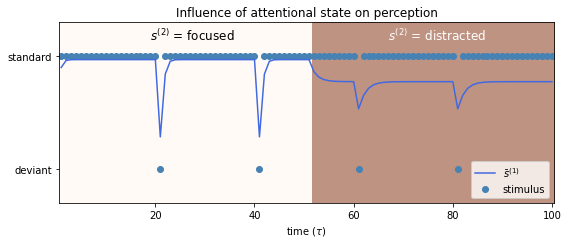

In [ ]:
###Figure 7
plt.figure(figsize=(8,3.5))

if 0:

  plt.subplot(2,1,1)
  #plt.plot(1+np.arange(T),X2[0,:],label=r'${x}^{(2)}$',linestyle='--')
  #plt.plot(1+np.arange(T),X2bar[0,:],label=r'${\bar{x}}^{(2)}$')

  plt.scatter(1+np.arange(T),1-x2,label='true state',color='green')
  #plt.plot(X2bar[1,:],label='distracted')

  plt.ylim([-0.1,1.1])
  plt.yticks([0,1],['distracted','focused'])
  plt.ylabel(r'$x^{(2)}$')
  plt.title('attentional state')
  #plt.legend()
  plt.xlim([0.5,T+0.5])

plt.subplot(1,1,1)

plt.imshow([0.5*(0.5*x2),0.5*(0.5*x2)], aspect='auto',cmap='Oranges',alpha=0.5,extent=[0.5,100.5,-0.3,1.3])
#extent=[0.5,100.5,-0.25,1.25],
#plt.imshow([X2bar[0,:],X2bar[0,:]], aspect='auto',cmap='gray',interpolation='gaussian',extent=[0.5,100.5,0,1])

#plt.plot(1+np.arange(T),X1[0,:],label=r'$x^{(1)}$',linestyle='--',color='blue')
plt.plot(1+np.arange(T),X1bar[0,:],label=r'${\bar{s}}^{(1)}$',color='royalblue')
plt.yticks([0,1],['deviant','standard'])
#plt.colorbar(label=r'${\bar{x}}^{(2)}$')
#plt.ylabel(r'$x^{(1)}$')
plt.xlabel(r'time ($\tau$)')
plt.scatter(1+np.arange(T),1-O,label='stimulus',color='steelblue')
plt.text(19,1.14,r'$s^{(2)}$ = focused',fontsize = '12')
plt.text(67,1.14,r'$s^{(2)}$ = distracted',color='white',fontsize = '12')
plt.title('Influence of attentional state on perception')
plt.legend(loc = 'lower right')
plt.ylim([-0.3,1.3])
plt.xlim([0.5,T+0.5])


plt.tight_layout()
plt.savefig("figure_7.tiff", dpi = 600)
files.download("figure_7.tiff")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

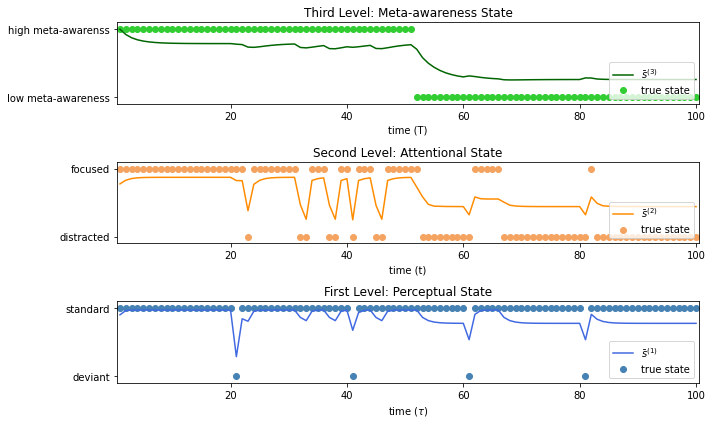

In [ ]:
####for figure 11:

####### Mind-wandering during an odd-ball perceptual task
####### Three level model with single factor at each level

################################################################################
### Defining parameters
################################################################################

fig7=0                      ### Setting parameters for each figure
fig10=0
fig11=1


T = 100                     ### Number of time-steps
Pi2 = np.zeros((2,T))       ### prior attentional actions (stay, switch)
Pi2bar = np.zeros((2,T))    ### posterior attentional actions (stay, switch)

E2 = np.array([0.99,0.50])    ### prior over attentional policies
gammaG2 = 2.0
C2 = np.array([2,-2])       ### preference over attentional outcomes (agent is trying to perform the task - ie. maintain attention on the stimulous)

X3 = np.zeros((2,T))        ### meta-awareness states prior (high vs low precision)
X3bar = np.zeros((2,T))     ### meta-awareness states posterior (high vs low precision)
x3 = np.zeros(T)            ### discrete generative process states --> x3 sets gammaA2
x3[0] = 0                   ### start in a high meta-awareness state

X2 = np.zeros((2,T))        ### attentional states prior (high vs low precision)
X2bar = np.zeros((2,T))     ### attentional states posterior (high vs low precision)

x2 = np.zeros(T)            ### discrete generative process states --> x2 sets gammaA1
x2[0] = 0                   ### start in a focused state
u2 = np.zeros(T)            ### discrete generative process active states --> u2 sets transition probabilities for x2


X1 = np.zeros((2,T))        ### perception prior (standard vs oddball)
X1bar = np.zeros((2,T))     ### perception posterior (standard vs oddball)

O = np.zeros(T)             ### observations (standard vs oddball)

O[int(T/5)]=1;              ### generative process determined by experimenter
O[int(2*T/5)]=1;              ### generative process determined by experimenter
O[int(3*T/5)]=1;              ### generative process determined by experimenter
O[int(4*T/5)]=1;              ### generative process determined by experimenter


O1 = np.zeros((2,T))        ### observation prior (standard vs oddball)
O1bar = np.zeros((2,T))     ### observation posterior (standard vs oddball)
for t in range(T):
  O1bar[int(O[t]),t]=1

O2bar = np.zeros((2,T))     ### observation posterior on the second level (focused vs distracted)


X3[:,0] = [1,0]           ### meta-awareness state prior D3
X2[:,0] = [0.5,0.5]         ### attentional state prior D2
X1[:,0] = [0.5,0.5]         ### perceptual state prior D1

######## Defining transition matrices  ##########

B3 = np.zeros((2,2))
B3[:,0]=[.9,0.1]            ###probability of high/low meta-awareness, given high meta-awareness
B3[:,1]=[0.1,.9]            ###probability of high/low meta-awareness, given low meta-awareness


B2a = np.zeros((2,2))       ### maintain attentional state - "stay"
B2b = np.zeros((2,2))       ### switch atttentional state - "switch"

B2a[:,0]=[.8,0.2]           ###probability of focus/distracted, given focus+stay
B2a[:,1]=[0.0,1.0]          ###probability of focus/distracted, given distracted+stay

B2b[:,0]=[0.0,1.0]          ###probability of focus/distracted, given focus+switch
B2b[:,1]=[1.0,0.0]          ###probability of focus/distracted, given distracted+switch

B2t = np.zeros((2,2,2))
B2t[:,:,0]=B2a
B2t[:,:,1]=B2b

B1 = np.zeros((2,2))
B1[:,0]=[0.8,0.2]
B1[:,1]=[0.2,0.8]

######## Defining likelihood matrices  ##########

A1 = np.zeros((2,2))
A1[:,0] = [0.75,0.25]
A1[:,1] = [0.25,0.75]
gammaA1 = np.zeros(T)
betaA1m = np.array([0.5,2.0])

A2 = np.zeros((2,2))
A2[:,0] = [0.65,0.35]
A2[:,1] = [0.35,0.65]
gammaA2 = np.zeros(T)
betaA2m = np.array([0.5,2.0])

A3 = np.zeros((2,2))
A3[:,0] = [0.9,0.1]
A3[:,1] = [0.1,0.9]

######## Setting up F & G calculations #######

H2 = np.zeros(2)
H2[0] = np.inner(A2,np.log(A2))[0,0]
H2[1] = np.inner(A2,np.log(A2))[1,1]

G2 = np.zeros((2,T))
F2 = np.zeros((2,T))

################################################################################
### Running the simulation
################################################################################


### State belief updating
for t in range(T):
  ###meta-awareness level X3:
  betaA2 = np.sum(betaA2m*np.inner(A3,X3[:,t])) ### Bayesian model average (prior precision beliefs)
  gammaA2[t] = betaA2m[int(x3[t])]**-1          ### actual precision is based on generative process (earlier it was betaA2**-1)
  A2bar = softmax_dim2(np.log(A2)*gammaA2[t])
  O2bar[int(x2[t]),t]=1 ###set the true lower-level attentional states as observations to inform the meta-awareness charge

  ###attentional level X2:
  betaA1 = np.sum(betaA1m*np.inner(A2bar,X2[:,t]))  ### Bayesian model average (prior precision beliefs)
  gammaA1[t] = betaA1m[int(x2[t])]**-1              ### actual precision is based on generative process (earlier it was betaA1**-1)
  A1bar = softmax_dim2(np.log(A1)*gammaA1[t])              ### Precision weighted likelihood mapping

  ###perceptual level X1:
  O1[:,t] = np.inner(A1bar,X1[:,t])                                        ### Observation priors
  X1bar[:,t] = softmax(np.log(X1[:,t])+gammaA1[t]*np.log(A1[int(O[t]),:])) ## calculate perceptual state posterior


  ###calculating ascending message from X1->X2
  AtC = 0                                       ### "attentional charge" - inverse precision updating term
  for i in range(2):                            ##loop over outcomes
    for j in range(2):                          ##loop over states
      AtC += (O1bar[i,t]-A1bar[i,j])*X1bar[j,t]*np.log(A1[i,j])   ### See "Uncertainty, epistemics and active inference" Parr, Friston.
  if AtC > betaA1m[0]:
    AtC = betaA1m[0]-10**-5
  betaA1bar = betaA1 - AtC                      ## inverse precision posterior
  X2bar[:,t] = softmax(np.log(X2[:,t])-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))  ## calculate attentional state posterior given precision beliefs


  X2bar[:,t] = softmax(np.log(X2[:,t])+gammaA2[t]*np.log(A2[int(x2[t]),:])-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))


  ###calculating ascending message from X2->X3
  MaC = 0                                       ### "meta-awareness charge" - inverse precision updating term
  for i in range(2):                            ##loop over outcomes
    for j in range(2):                          ##loop over states
      MaC += (O2bar[i,t]-A2bar[i,j])*X2bar[j,t]*np.log(A2[i,j])   ### See "Uncertainty, epistemics and active inference" Parr, Friston.
  if MaC > betaA2m[0]:
    MaC = betaA2m[0]-10**-5
  betaA2bar = betaA2 - MaC                      ## inverse precision posterior
  X3bar[:,t] = softmax(np.log(X3[:,t])+0.1*np.log(A3[int(x3[t]),:])-1.0*np.log((betaA2m-MaC)/betaA2m*betaA2/betaA2bar))  ## calculate meta-awareness state posterior given precision beliefs



### Policy selection

  if t<(T-1):
    X2a = np.inner(B2a,X2bar[:,t])
    O2a = np.inner(A2,X2a)

    X2b = np.inner(B2b,X2bar[:,t])
    O2b = np.inner(A2,X2b)

    #print("t:",t, "X2a:",X2a, "X2b:", X2b, "X2bar:",X2bar[:,t])

    G2[0,t] = np.sum(O2a*(np.log(O2a)-C2)-X2a*H2)
    G2[1,t] = np.sum(O2b*(np.log(O2b)-C2)-X2b*H2)
    #print("O2a:",O2a,"O2b:",O2b)
    Pi2[:,t] = softmax(np.log(E2)-gammaG2*G2[:,t])
    #print("Pi2:",Pi2[:,t],"G2:",G2[:,t])


    B2 = B2a*Pi2[0,t]+B2b*Pi2[1,t]

    X3[:,t+1] = np.inner(B3,X3bar[:,t])
    X2[:,t+1] = np.inner(B2,X2bar[:,t]) ###evolve expected state
    X1[:,t+1] = np.inner(B1,X1bar[:,t])

    u2[t] = np.arange(2)[Pi2[:,t]==np.amax(Pi2[:,t])] ###generative process is discrete

     ### generative process driving attentional states
    if fig7:
      if t<T/2:
        x2[t+1] = 0 ##set to focused
      else:
        x2[t+1] = 1 ##set to distracted
    else:
      if u2[t]==0:
        x2[t+1] = np.random.choice([0,1],p=B2a[:,int(x2[t])]) ###generate true state from action 0
      else:
        x2[t+1] = np.random.choice([0,1],p=B2b[:,int(x2[t])]) ###generate true state from action 1

    if fig11:
      if t<T/2:
        x3[t+1]=0
      else:
        x3[t+1]=1
    else:
      x3[t+1] = np.random.choice([0,1],p=B3[:,int(x3[t])]) ###generate true state



  X2abar = softmax(np.log(X2a)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))
  X2bbar = softmax(np.log(X2b)-1.0*np.log((betaA1m-AtC)/betaA1m*betaA1/betaA1bar))


  if t>0:
    F2[0,t-1] = np.sum(X2abar*(np.log(X2abar)-np.log(A2[int(x2[t]),:])-np.log(X2a)))
    F2[1,t-1] = np.sum(X2bbar*(np.log(X2bbar)-np.log(A2[int(x2[t]),:])-np.log(X2b)))

    #print("F2:",F2[:,t-1])
    Pi2bar[:,t-1]=softmax(np.log(E2)-gammaG2*G2[:,t-1]-F2[:,t-1])


################################################################################
### Plotting results
################################################################################


plt.figure(figsize=(10,6))

plt.subplot(3,1,1)
#plt.plot(1+np.arange(T),X2[0,:],label=r'${x}^{(2)}$',linestyle='--')
plt.plot(1+np.arange(T),X3bar[0,:],label=r'${\bar{s}}^{(3)}$',color='darkgreen')
plt.scatter(1+np.arange(T),1-x3,label='true state',color='limegreen')
#plt.imshow([0.5*(1-0.5*x2),0.5*(1-0.5*x2)], aspect='auto',cmap='gray',alpha=0.3,extent=[0.5,100.5,-0.3,1.3])
#plt.plot(X2bar[1,:],label='distracted')
plt.ylim([-0.1,1.1])
plt.yticks([0,1],['low meta-awareness','high meta-awarenss'])
plt.xlabel('time (T)')
#plt.ylabel(r'$x^{(2)}$')
plt.title('Third Level: Meta-awareness State')
plt.legend(loc = 'lower right')
plt.xlim([0.5,T+0.5])

#plt.subplot(4,1,2)
#plt.plot(1.5+np.arange(0,T-1),Pi2[0,:-1],label='stay (prior)',linestyle='--')
#plt.plot(np.arange(1,T),Pi2[1,:-1],label='switch (prior')
#plt.plot(1.5+np.arange(0,T-1),Pi2bar[0,:-1],label=r'${\bar{\pi}}^{(2)}$',color='coral')
#plt.plot(np.arange(1,T),Pi2[1,:-1],label='switch (posterior)',linestyle='--')
#plt.scatter(1+np.arange(T),1-u2,label='true action',color='orangered')
#plt.legend(loc = 'lower right')
#plt.ylim([0,1.0])
#plt.yticks([0,1],['switch','stay'])
#plt.ylabel(r'$\pi^{(2)}$')
#plt.title('Second Level: Attentional Action')
#plt.xlim([0.5,T+0.5])
#plt.xlabel('time (t)')

plt.subplot(3,1,2)
#plt.plot(1+np.arange(T),X2[0,:],label=r'${x}^{(2)}$',linestyle='--')
plt.plot(1+np.arange(T),X2bar[0,:],label=r'${\bar{s}}^{(2)}$',color='darkorange')
plt.scatter(1+np.arange(T),1-x2,label='true state',color='sandybrown')
#plt.imshow([0.5*(1-0.5*x2),0.5*(1-0.5*x2)], aspect='auto',cmap='gray',alpha=0.3,extent=[0.5,100.5,-0.3,1.3])
#plt.plot(X2bar[1,:],label='distracted')
plt.ylim([-0.1,1.1])
plt.yticks([0,1],['distracted','focused'])
plt.xlabel('time (t)')
#plt.ylabel(r'$x^{(2)}$')
plt.title('Second Level: Attentional State')
plt.legend(loc = 'lower right')
plt.xlim([0.5,T+0.5])

plt.subplot(3,1,3)
#plt.plot(1+np.arange(T),X1[0,:],label=r'$x^{(1)}$',linestyle='--')
plt.plot(1+np.arange(T),X1bar[0,:],label=r'${\bar{s}}^{(1)}$',color='royalblue')
plt.yticks([0,1],['deviant','standard'])
plt.xlabel(r'time ($\tau$)')
plt.scatter(1+np.arange(T),1-O,label='true state',color='steelblue')
plt.title('First Level: Perceptual State')
plt.legend(loc = 'lower right')
plt.ylim([-0.1,1.1])
plt.xlim([0.5,T+0.5])


plt.tight_layout()
plt.savefig("figure_11.tiff", dpi = 600)
# files.download("figure_11.tiff")